In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### MNIST
Imagens de números e sua classificação

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

y = y.astype(np.uint8)

X.shape, y.shape

((70000, 784), (70000,))

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

Label: 5


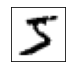

In [5]:
print("Label:", y[0])

plt.figure(figsize=(1, 1))
plt.imshow(some_digit_image, cmap="binary")
plt.xticks([]), plt.yticks([]);

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    
    images_per_row = min(len(instances), images_per_row)
    
    images = [instance.reshape(size, size) for instance in instances]
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)

    plt.axis("off")
    return image

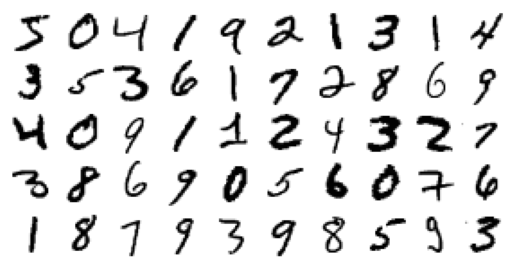

In [7]:
plt.figure(figsize=(9, 9))

example_images = X[:50]
plot_digits(example_images, images_per_row=10)

plt.show()

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 1. Training a Binary Classifier
Classes: 5 e not-5

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
from sklearn.metrics import accuracy_score

sgd_pred = sgd_clf.predict(X_train)

accuracy_score(y_train_5, sgd_pred)

0.9522666666666667

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
y_train_5[0]

True

O classificador acertou o valor dado. Vamos avaliar para todos os dados.

### 2. Performance Measures
Avaliar classificadores é, geralmente, mais complicado do que avaliar um regressor.

#### 2.1 Cross-Validation
Uma boa forma de começar é usar o Cross-Validation calculando a acaurácia.

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
y_train_5.mean()

0.09035

Nosso modelo não está overfitting, pois o contraste entre a acurácia obtida das predições do conjunto de treino e do conjunto de validação é baixíssimo.

Nossa acurácia está com um valor bastante alto. Isso significa que nosso modelo está perfeito? Temos que ver a proporção das classes.

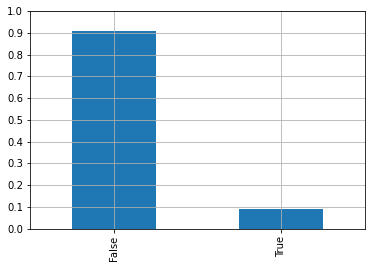

In [16]:
pd.Series(y_train_5).value_counts(normalize=True).plot(kind="bar")
plt.yticks(np.arange(0, 1+.1, .1)), plt.grid(True);

Como as classes estão extremamente desbalanceadas, se eu tiver um modelo que classifica todos os valores como a classe mais frequente, eu vou obter uma acurácia muito próxima à proporção da classe mais frequente.

Por isso, geralmente a acurácia não é a performance preferida para avaliar os modelos de classificação, rincipalmente quando as classes são muito desbalanceadas.

Para confirmar essa questão, vamos criar um classificador que classifica todo mundo como não-5 e calcular a acurácia.

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

#### 2.2 Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [21]:
sgd_clf.classes_

array([False,  True])

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Cada linha na matriz de confusão representa a classe real, enquanto cada coluna representa a classe inferida. O modelo perfeito seria aquele em que a diagonal da matriz esteja preenchida e qualquer outros valor que não a diagonal seja 0.

- Precision: Dos valores que foram inferidos como True, qual, de fato, é a proporção de True.
- Recall: De todos os valores que são True, qual a proporção de valores que foram classificados como True.

In [23]:
precision = 3530 / (3530+687)
recall = 3530 / (1891+3530)

np.round([precision, recall], 3)

array([0.837, 0.651])

In [24]:
from sklearn.metrics import precision_score, recall_score

pcs = precision_score(y_train_5, y_train_pred)
rcl = recall_score(y_train_5, y_train_pred)

np.round([pcs, rcl], 3)

array([0.837, 0.651])

#### 2.3 F1 Score

Geralmente, é conveniente combinar a precisão e o recall em uma métrica única chamada F1-Score.

O F1 Score á a média harmônica da precisão e do recall. Enquanto a média aritmética trata os valores igualmente, a média harmônica dá muito mais peso aos valores mais baixos. Como resultado, o calssificador só obterá F1 Score elevado se ambos o recall e a precisão forem altos.

In [25]:
from sklearn.metrics import f1_score

f1s = f1_score(y_train_5, y_train_pred)

np.round(f1s, 3)

0.733

O F1 Score favore modelos cuja precisão e recall sejam parecidos. Não é sempre o que queremos: em alguns contextos você irá preferir mais precisião do que recall, ou vice-versa.

**Exemplo onde se prefere PRECISION**: 

- Classe (+): Conteúdo seguro para criança 
- Classe (-): Conteúdo inseguro para criança
    
Iremos preferir precisão mais alta. Isso significa que muitos conteúdos seguros para criança serão classificados como inseguros (recall baixo), porém sempre que você classificar que um conteúdo é seguro para criança, você terá muita certeza disso (precisão alta).


**Exemplo onde se prefere RECALL**: 

- Classe (+): Pessoa suspeita
- Classe (-): Pessoa não suspeita. 

Iremos preferir recall mais alto, pois é preferível suspeitar de mais pessoas, mesmo que isso signifique suspeitar de inocente (recall alto), do que apenas suspeitar de alguém quando você tem muita certeza que alguém é suspeito (precisão baixa).

#### 2.4 Precision/Recall Trade-Off

Alguns algoritmos de classificação calculam, para cada instância, um score baseado em uma função de decisão. Se o Score for acima de um threshold definido, ele classifica a instância como a classe positiva.

In [26]:
y_score = sgd_clf.decision_function([some_digit])
y_score

threshold = 0

y_score > threshold

array([ True])

In [27]:
y_scores = sgd_clf.decision_function(X_train)
y_scores

array([  2164.22030239,  -5897.37359354, -13489.14805779, ...,
         6007.43513003,   -695.89564908,  -3991.49590678])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, ..., False, False, False])

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

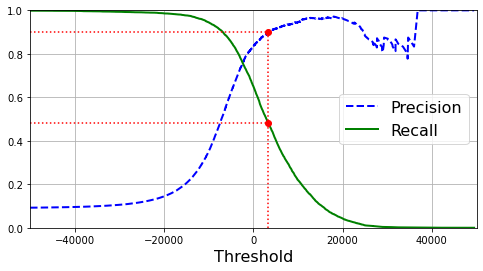

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, lims=[-50000, 50000, 0, 1]):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)
    plt.axis(lims)


ind_frst_pcs_gt_90 = np.argmax(precisions >= .9)

recall_90_precision = recalls[ind_frst_pcs_gt_90]
threshold_90_precision = thresholds[ind_frst_pcs_gt_90]


plt.figure(figsize=(8, 4))

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")

plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
                                            
plt.show()

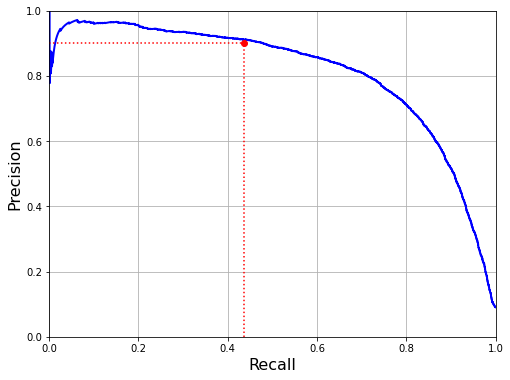

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))

plot_precision_vs_recall(precisions, recalls)

plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")

plt.show()

#### TIP
Se alguém diz, "Vamos tentar 99% de precisão", devemos perguntar, "Com qual recall?"

#### 2.5 The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR).

The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called Specificity.

Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

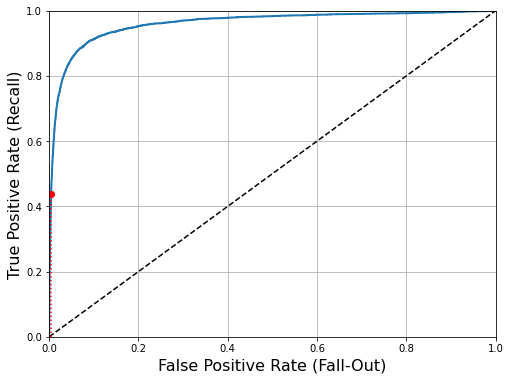

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6)) 

plot_roc_curve(fpr, tpr)

plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:") 
plt.plot([4.837e-3], [0.4368], "ro")

plt.show()

##### AUC -  Area Under the Curve (ROC curve)
Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### TIP
Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. 

As a rule of thumb, you should prefer:
- the PR curve, whenever the positive class is rare or when you care more about the false positives than the false negatives
- the ROC curve, otherwise.

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

**Let’s now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier.**

First, you need to get scores for each instance in the training set. 

But due to the way it works, the RandomForestClassifier class does not have a `decision_function()` method. Instead, it has a `predict_proba()` method. 

Scikit-Learn classifiers generally have one or the other, or both. 

The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [37]:
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

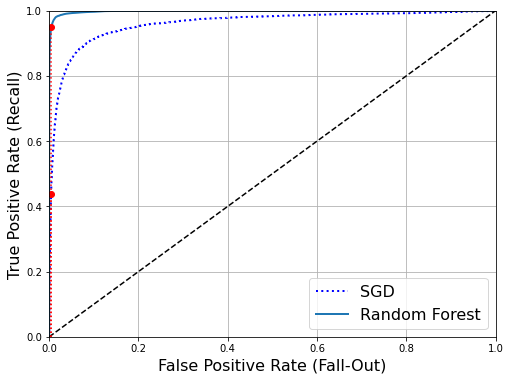

In [38]:
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")

plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [39]:
roc_auc = np.round(roc_auc_score(y_train_5, y_scores_forest), 3)
roc_auc

0.998

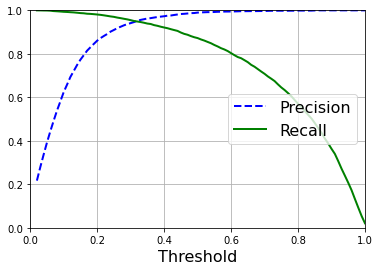

In [40]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest, lims=[0, 1, 0, 1])

### 3. Multiclass Classification

Alguns algoritmos (Regressão Logística, Random Forest, Decision Tree e Naive Bayes) são capazes de lidar com múltiplas classes de forma nativa. Outros modelos (SGD, SVM) são estritamentes binários. Entretanto, existem várias estratégias para performar classificações de múltiplas classes com classificadores binários.

##### 3.1 One-Versus-All; One-Versus-Rest (OvR) strategy.
Nosso caso possui 10 classes (0 a 9)
Treinaremos 10 classificadores, um classificador para cada classe.
- Detector de 0
- Detector de 1
- Detector de 2
- ...
- Detector de 9

##### 3.2 One-Versus-One (OvO) strategy.
Número de classificadores N x (N - 1) / 2.
No nosso caso, a gente precisará treinar 45 classificadores.
- Detector 0 e 1
- Detector 0 e 2
- Detector 0 e 3
- ...
- Detector 9 e 8

A principal vantagem do OvO é que cada classificador precisa ser treinado apenas com a parte do conjunto de treino que tem as duas classes que ele quer distinguir. No nosso caso, cada classificador vai ser treinado apenas com 20% do conjunto de treino.

In [41]:
# from sklearn.svm import SVC

# svm_clf = SVC(gamma="auto", random_state=42)
# svm_clf.fit(X_train, y_train)

# svm_cf.predict([some_digit])

In [42]:
# from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# ovr_clf = OneVsOneClassifier(SVC(gamma="auto", random_state=42))
# ovr_clf.fit(X_train, y_train)

In [43]:
# ovr_clf.predict([some_digit])

In [44]:
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

### 4. Error Analysis
Assumindo que encontramos modelos promissores e que queremos melhorá-los, uma forma de melhorar seria analisar os erros cometidos.

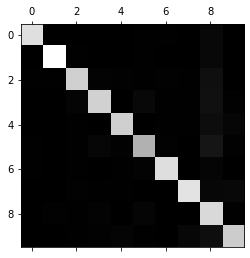

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.gray)

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

norm_conf_mx = conf_mx / row_sums

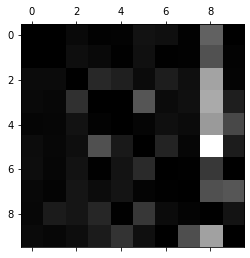

In [48]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()